#### Credits to Foam Liu https://github.com/foamliu/Car-Recognition

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#print(os.listdir("../input/devkit/devkit"))

import scipy.io
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model,Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
import cv2#reading and resizing                      
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from resnet_152 import resnet152_model

# Prepare Data

In [5]:
meta_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_meta.mat')
train_annos_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_train_annos.mat')
test_annos_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_test_annos.mat')
annos_dict = [train_annos_dict,test_annos_dict]

In [6]:
# Load cars_meta into dataFrame
meta_df = pd.DataFrame.from_dict(meta_dict['class_names'])
meta_df = meta_df.stack()
len(meta_df)

196

In [7]:
# Load train and test annos into dataFrame
for i,d in enumerate(annos_dict):
    r,c = d['annotations'].shape
    d_reshape = d['annotations'].reshape(c,r)
    d_reshape.shape
    
    if i == 0:
        d_df = pd.DataFrame(data = np.hstack((d_reshape[:]['bbox_x1'],d_reshape[:]['bbox_y1'],d_reshape[:]['bbox_x2'],
                                            d_reshape[:]['bbox_y2'],d_reshape[:]['class'],d_reshape[:]['fname'])))
        d_df.rename(index=str,columns={0:'bbox_x1',1:'bbox_y1',2:'bbox_x2',3:'bbox_y2',4:'class',5:'fname'},inplace=True)
    else:
        d_df = pd.DataFrame(data = np.hstack((d_reshape[:]['bbox_x1'],d_reshape[:]['bbox_y1'],d_reshape[:]['bbox_x2'],
                                            d_reshape[:]['bbox_y2'],d_reshape[:]['fname'])))
        d_df.rename(index=str,columns={0:'bbox_x1',1:'bbox_y1',2:'bbox_x2',3:'bbox_y2',4:'fname'},inplace=True)

    for col in d_df.columns:
        l = d_df[col]  
        flatten = lambda l: [item for sublist in l for item in sublist]
        if col == 'fname':
            pass
        else:
            d_df[col] = d_df[col].apply(flatten)

        d_df[col] = d_df[col].apply(lambda i: i[0])
    
    if i == 0:
        train_annot_df = d_df.copy()
    else:
        test_annot_df = d_df.copy()

# Split data to train, evaluation and test

In [8]:
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [9]:
X = train_annot_df.drop('class',axis=1)
y = train_annot_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

train_df = pd.concat([X_train,y_train],axis=1)
val_df = pd.concat([X_val,y_val],axis=1)
test_df = pd.concat([X_test,y_test],axis=1)

In [10]:
# Convert column class to string
train_df['class'] = train_df['class'].apply(str)
val_df['class'] = val_df['class'].apply(str)
test_df['class'] = test_df['class'].apply(str)

In [11]:
print(train_annot_df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(8144, 6)
(3990, 6)
(1710, 6)
(2444, 6)


In [12]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

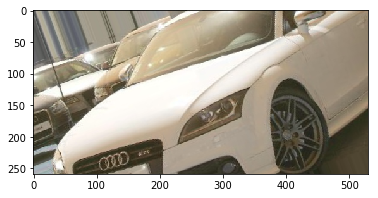

In [14]:
img = cv2.imread('Cars_Dataset_Stanford/cars_train_cropped/00001.jpg')
plt.imshow(image_gen.random_transform(img))
#plt.imshow(img)

# Find image size median

In [15]:
# Find median of image size
height_list = []
width_list = []

for i in range(len(train_annot_df)):
    path = 'Cars_Dataset_Stanford/cars_train_cropped/' + train_annot_df['fname'][i]
    img = cv2.imread(path)
    height,width = img.shape[:2]
    height_list.append(height)
    width_list.append(width)

In [28]:
img_height = int(np.median(height_list))
img_width = int(np.median(width_list))

print(img_height)
print(img_width)

260
504


# Creating the Model

In [ ]:
'''
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer
model.add(Dense(196))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
'''

In [23]:
def resnet152_model(img_rows, img_cols, color_type=1, num_classes=None):
    """
    Resnet 152 Model for Keras
    Model Schema and layer naming follow that of the original Caffe implementation
    https://github.com/KaimingHe/deep-residual-networks
    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/file/d/0Byy2AcGyEVxfZHhUT3lWVWxRN28/view?usp=sharing
    TensorFlow: https://drive.google.com/file/d/0Byy2AcGyEVxfeXExMzNNOHpEODg/view?usp=sharing
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """
    eps = 1.1e-5

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
          img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:
          bn_axis = 1
            img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name='bn_conv1')(x)
    x = Scale(axis=bn_axis, name='scale_conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(1,8):
          x = identity_block(x, 3, [128, 128, 512], stage=3, block='b'+str(i))

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1,36):
          x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b'+str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)

    model = Model(img_input, x_fc)

    if K.image_dim_ordering() == 'th':
      # Use pre-trained weights for Theano backend
      weights_path = 'models/resnet152_weights_th.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = 'models/resnet152_weights_tf.h5'

    model.load_weights(weights_path, by_name=True)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='fc8')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [37]:
num_channels = 3
num_classes = len(meta_df)

model = resnet152_model(img_height, img_width, num_channels, num_classes)

ValueError: Layer #721 (named "fc1000"), weight <tf.Variable 'fc1000_2/kernel:0' shape=(4096, 1000) dtype=float32_ref> has shape (4096, 1000), but the saved weight has shape (2048, 1000).

In [ ]:
model.summary()

# Training the Model

In [ ]:
patience = 50
verbose = 1
batch_size = 16
num_epochs = 100000
patience = 50

In [ ]:
tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
log_file_path = 'logs/training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_acc', patience=patience)
reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)
trained_models_path = 'models/model'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]

In [ ]:
batch_size = 16

train_generator = image_gen.flow_from_dataframe(
                    dataframe = train_df,
                    directory = '../input/cars-train-cropped/cars_train_cropped/',
                    x_col = 'fname',
                    y_col = 'class',
                    class_mode = 'categorical',
                    batch_size = batch_size,
                    target_size=image_shape[:2])

In [ ]:
test_generator = image_gen.flow_from_dataframe(
                    dataframe = test_df,
                    directory = '../input/cars-train-cropped/cars_train_cropped/',
                    x_col = 'fname',
                    y_col = 'class',
                    class_mode = 'categorical',
                    batch_size = batch_size,
                    target_size=image_shape[:2])

In [ ]:
results = model.fit_generator(train_generator,epochs=100,
                              steps_per_epoch=150,
                              validation_data=test_generator,
                              validation_steps=12)

In [ ]:
model.save('cars_090619.h5')

In [ ]:
plt.plot(results.history['acc'])

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 394006020750715990
]
